In [5]:
import tensorflow as tf 
import tensorflow.keras as tfk 
import numpy as np 
import matplotlib.pyplot as plt 
import os
from scipy.integrate import solve_ivp

import sys
from utils import *
sys.path.insert(1, "../src/")
from sindy_utils import *

from utils import *

seed = 42
tf.random.set_seed(seed)

## Model architecture

In [6]:
def build_encoder(input_shape, latent_dim = 1):
    encoder_inputs = tfk.Input(shape=(input_shape,)) 
    
    #initially following parameters outlined in sindy paper 
    activation = "sigmoid"
    x = tfk.layers.Dense(128, activation=activation, kernel_initializer = tfk.initializers.GlorotNormal(seed=seed))(encoder_inputs)
    x = tfk.layers.Dense(64, activation=activation, kernel_initializer = tfk.initializers.GlorotNormal(seed=seed))(x)
    x = tfk.layers.Dense(32, activation=activation, kernel_initializer = tfk.initializers.GlorotNormal(seed=seed))(x)
    z = tfk.layers.Dense(latent_dim, 
                         activation='linear', 
                         kernel_initializer = tfk.initializers.GlorotNormal(seed=seed))(x)

    encoder = tfk.Model(encoder_inputs, z, name="encoder")
    return encoder


def build_decoder(output_shape, latent_dim = 1):
    decoder_inputs = tfk.Input(shape=(latent_dim,))
    
    #initially following parameters outlined in sindy paper 
    activation = "sigmoid"
    x = tfk.layers.Dense(32, activation=activation, kernel_initializer = tfk.initializers.GlorotNormal(seed=seed))(decoder_inputs)
    x = tfk.layers.Dense(64, activation=activation, kernel_initializer = tfk.initializers.GlorotNormal(seed=seed))(x)
    x = tfk.layers.Dense(128, activation=activation, kernel_initializer = tfk.initializers.GlorotNormal(seed=seed))(x)
    x = tfk.layers.Dense(output_shape, 
                         activation="linear", 
                         kernel_initializer = tfk.initializers.GlorotNormal(seed=seed))(x) 

    #no params!
    reconstructed = tfk.layers.Activation(tfk.activations.sigmoid)(x)
    
    #in this form its as if we have 2 outputs, where the derivatives go through a model with linear output and
    #the reconstructions are softmaxed 
    
    
    decoder = tfk.Model(decoder_inputs, reconstructed, name="decoder")
    return decoder

In [7]:
#need to define activations for more flexible derivative taking 
encoder_activations = ['sigmoid' for i in range(3)]
encoder_activations.append('linear')
decoder_activations = ['sigmoid' for i in range(3)]
decoder_activations.append('linear') #only relevant for the derivative taking 

print(encoder_activations, decoder_activations)

#i wish keras layers let you access the activation type but unfortunately not -- wait! 
#i can subclass a layer and during the init create a variable that lets me define its activation as a string
#... more in the notion file 

['sigmoid', 'sigmoid', 'sigmoid', 'linear'] ['sigmoid', 'sigmoid', 'sigmoid', 'linear']


In [8]:
class DAE(tfk.Model):
    def __init__(self, encoder, decoder, encoder_activations, decoder_activations, **kwargs):
        super().__init__(**kwargs) #pass kwargs to delegating constructor in parent class 
        self.encoder = encoder
        self.decoder = decoder
        self.encoder_activations = encoder_activations
        self.decoder_activations = decoder_activations
        
        
        
        #stateful metrics 
        self.total_loss_tracker = tfk.metrics.Mean(name="total_loss")
        self.decoder_loss_tracker = tfk.metrics.Mean(name="decoder_loss")
        self.sindy_z_loss_tracker = tfk.metrics.Mean(name="sindy_z_loss")
        self.sindy_x_loss_tracker = tfk.metrics.Mean(name="sindy_x_loss")
        self.sindy_regularization_loss_tracker = tfk.metrics.Mean(name="sindy_regularization_loss")
        
        self.Xi_hist = [] #prolly a better way 
        

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.decoder_loss_tracker,
            self.sindy_z_loss_tracker,
            self.sindy_x_loss_tracker,
            self.sindy_regularization_loss_tracker,
        ]
    
    def call(self, inputs):
        '''
        should return the reconsrtuction, as well as derivatives of the reconstruction, maybe xi updated internally 
        '''
        
        pass 
        
        
    
    def sindy_fit(self, latent_info):
        """
        ols regression to determine & update the sindy coefficients 
        
        consider doing this manually so we are exposing the actual embeddings more; idea would to pivot this into 
        the (X'X)^{-1}X'Y formulation directly in the training step 
        """
        z, dz, ddz = latent_info
        Z = tf.squeeze(tf.stack((z,dz), axis=1), -1)#squeeze gets rid of extra dim
        
        #should be sufficient for identifying spring dynamics
        lib = sindy_library(Z.numpy(), poly_order = 2, include_sine = False) 
        
        #print(f'lib rank: {np.linalg.matrix_rank(lib)}, min dim: {min(lib.shape[0], lib.shape[1])}, invertible? {np.linalg.matrix_rank(lib)==min(lib.shape[0], lib.shape[1])}')

        b = tf.squeeze(tf.stack((ddz,dz), axis=1))
        
        #Xi = tf.linalg.lstsq(lib, b) #me 
        Xi = sindy_fit(lib, b.numpy(), 0.1) #sindy 
        
        self.Xi_hist.append(tf.convert_to_tensor(Xi))
        
        lib = tf.convert_to_tensor(lib, dtype='float32')
        ddz_out = tf.linalg.matmul(lib,Xi)
        
        return tf.expand_dims(ddz_out[:,0], -1) #only extracting the estimate of the second derivative 
        

## Data prep 

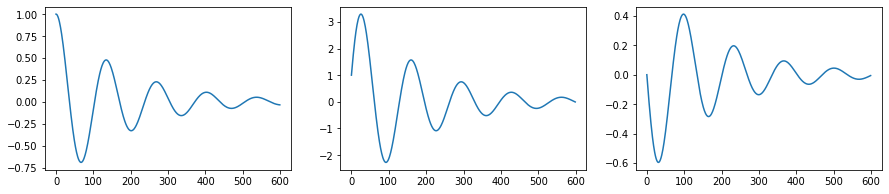

In [9]:
#let's generate 3 spring systems under different dampening conditions but same ic's
x0 = [1, 0]
dt = 1/30
t = np.arange(0, 20, dt)

params1 = {'c':0.33, 'm':0.5, 'k':1}
#params2 = {'c':3., 'm':0.5, 'k':1} #commenting these out ensure same system params 
#params3 = {'c':1, 'm':0.5, 'k':1}


x_train1 = generate_spring_data(params1, t, x0)
x_train2 = generate_spring_data(params1, t, [1, 5])
x_train3 = generate_spring_data(params1, t, [0, -1])

fig, axs = plt.subplots(1,3, figsize=(15,3))
axs[0].plot(x_train1[:,0])
axs[1].plot(x_train2[:,0])
axs[2].plot(x_train3[:,0])

In [19]:
#converting positional information into synthetic video 
dim = 51

x1, dx1, ddx1 = spring_to_movie(x_train1[:,0], dt=dt, dim = dim)

x1 = np.reshape(x1, (x1.shape[0], dim*dim))
dx1 = np.reshape(dx1, (dx1.shape[0], dim*dim))
ddx1 = np.reshape(ddx1, (ddx1.shape[0], dim*dim))

x2, dx2, ddx2 = spring_to_movie(x_train2[:,0], dt=dt, dim = dim)

x2 = np.reshape(x2, (x2.shape[0], dim*dim))
dx2 = np.reshape(dx2, (dx2.shape[0], dim*dim))
ddx2 = np.reshape(ddx2, (ddx2.shape[0], dim*dim))

x3, dx3, ddx3 = spring_to_movie(x_train3[:,0], dt=dt, dim = dim)

x3 = np.reshape(x3, (x3.shape[0], dim*dim))
dx3 = np.reshape(dx3, (dx3.shape[0], dim*dim))
ddx3 = np.reshape(ddx3, (ddx3.shape[0], dim*dim))


x = np.concatenate((x1,x2,x3),0)
dx = np.concatenate((dx1,dx2,dx3),0)
ddx = np.concatenate((ddx1,ddx2,ddx3),0)

print(x.shape, dx.shape, ddx.shape)

(1800, 2601) (1800, 2601) (1800, 2601)


In [20]:
#converting to a tensorflow dataset object 
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((x, dx, ddx))
train_dataset = train_dataset.shuffle(buffer_size=64, seed = seed).batch(batch_size) #shuffle 

next(iter(train_dataset))[0].shape #nice 

TensorShape([32, 2601])

## Training

In [21]:
dae = DAE(build_encoder(dim*dim, latent_dim = 1), 
          build_decoder(dim*dim, latent_dim = 1),
          encoder_activations,
          decoder_activations)

dae.compile(optimizer=tfk.optimizers.Adam(5e-04), run_eagerly=True)

In [22]:
model = dae

@tf.function
def train_step(data):
    x, dx, ddx = data
    #print(x.shape, dx.shape)
    
    with tf.GradientTape() as tape:
        #extract latent rep and derivatives 
        z = model.encoder(x)
        dz,ddz = z_derivative2(model.encoder, data, model.encoder_activations) 
        
        #sindy fit, predict, decode 
        latent = (z,dz,ddz)
        ddz_predict = model.sindy_fit(latent)
        
        #in their code they use the real first derivative info instead of predicted 
        _, ddx_decode = z_derivative2(model.decoder, (z,dz,ddz_predict), model.decoder_activations)
        
        #reconstruction 
        reconstruction = model.decoder(z)

        ######### LOSSES ##########
        #use BCE for black and white pics 
        decoder_loss = tf.reduce_mean(
                tfk.losses.binary_crossentropy(x, reconstruction)
        )
        
        sindy_z_loss = tf.reduce_mean((ddz-ddz_predict)**2)
        sindy_x_loss = tf.reduce_mean((ddx-ddx_decode)**2)
        sindy_regularization_loss = tf.cast(tf.reduce_mean(tf.abs(model.Xi_hist[-1])), float)

        total_loss = decoder_loss + (5e-05)*sindy_z_loss + (5e-04)*sindy_x_loss + (1e-05)*sindy_regularization_loss
        #total_loss = decoder_loss + (5e-05)*sindy_z_loss

    #de-facto 
    grads = tape.gradient(total_loss, model.trainable_weights)
    model.optimizer.apply_gradients(zip(grads, model.trainable_weights)) 
    
    model.total_loss_tracker.update_state(total_loss)
    model.decoder_loss_tracker.update_state(decoder_loss)
    model.sindy_z_loss_tracker.update_state(sindy_z_loss)
    #model.sindy_x_loss_tracker.update_state(sindy_x_loss)
    #model.sindy_regularization_loss_tracker.update_state(sindy_regularization_loss)

    return {
        "loss": model.total_loss_tracker.result(),
        "decoder": model.decoder_loss_tracker.result(),
        "z": model.sindy_z_loss_tracker.result(),
        #"x": model.sindy_x_loss_tracker.result(),
        #"sindy": model.sindy_regularization_loss_tracker.result(),
    }

In [23]:
#run this for one epoch 
tf.config.run_functions_eagerly(True) #way faster without eager execution but you need it to interface with sindylib

epochs = 300
for epoch in range(epochs):

    #train step 
    for step, data in enumerate(train_dataset):
        losses = train_step(data)
    
    
    if(epoch%20 == 0):
        print(f'epoch: {epoch}\nlosses: {losses}') 

epoch: 0
losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.5339691>, 'decoder': <tf.Tensor: shape=(), dtype=float32, numpy=0.5191789>, 'z': <tf.Tensor: shape=(), dtype=float32, numpy=76.12468>}
epoch: 20
losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.16323744>, 'decoder': <tf.Tensor: shape=(), dtype=float32, numpy=0.088184126>, 'z': <tf.Tensor: shape=(), dtype=float32, numpy=614.4172>}
epoch: 40
losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.111816645>, 'decoder': <tf.Tensor: shape=(), dtype=float32, numpy=0.066714354>, 'z': <tf.Tensor: shape=(), dtype=float32, numpy=330.25696>}
epoch: 60
losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.09279063>, 'decoder': <tf.Tensor: shape=(), dtype=float32, numpy=0.05844517>, 'z': <tf.Tensor: shape=(), dtype=float32, numpy=232.99341>}
epoch: 80
losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.082943425>, 'decoder': <tf.Tensor: shape=(), dtype=float32, numpy=0.05401264>, 'z': <tf.Te

KeyboardInterrupt: 

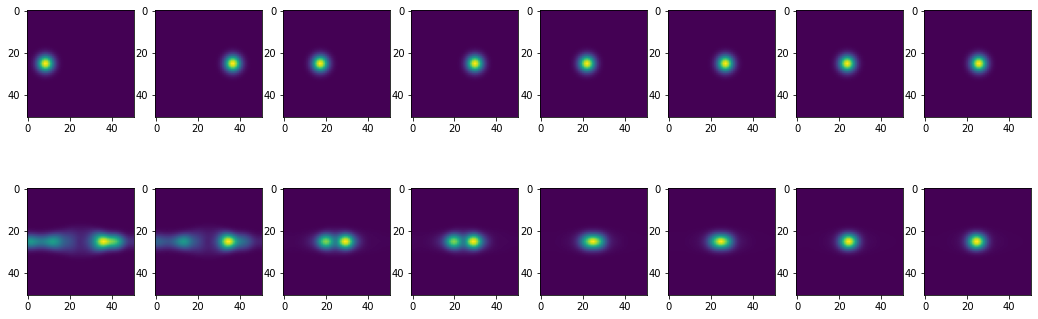

In [28]:
########## generate test data ##########
params2 = {'c':0.6, 'm':0.2, 'k':1}
x02 = [1, 1]
t2 = np.arange(0, 20, 0.1)
x_test = generate_spring_data(params2,t2,x02)

y, dy, ddy = spring_to_movie(x_test[:,0], dt=0.1, dim = dim)

y = np.reshape(y, (y.shape[0], dim*dim))
dy = np.reshape(dy, (dy.shape[0], dim*dim))
ddy = np.reshape(ddy, (ddy.shape[0], dim*dim))



########## predict #################
preds = dae.decoder(dae.encoder(y))

fig, axs = plt.subplots(2,8, figsize=(18,6))

j = 15
for i in range(8):
    axs[0][i].imshow(y[j*i].reshape(dim, dim))
    axs[1][i].imshow(preds[j*i].numpy().reshape(dim, dim))

In [25]:
tf.reduce_mean(dae.Xi_hist[-1:], axis=0)

<tf.Tensor: shape=(6, 2), dtype=float64, numpy=
array([[24.8819636 ,  0.        ],
       [ 9.23511893,  0.        ],
       [-1.54154598,  1.        ],
       [ 0.77835362,  0.        ],
       [-0.17055879,  0.        ],
       [-0.16310188,  0.        ]])>

In both the following derivative functions our forward propogations depend on the activations in the model passed to the function call.  relu is pretty good all things considered but in our decoder layer we end with a sigmoid so we need to provide some flexibility 